# Подкдючаем библиотеки

In [2]:
import torch

import torch.nn as nn

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

import tarfile

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm, trange

import time

import os

# Скачиваем датасет

In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [8]:
data_dir = './data/cifar10'
dataTrain = ImageFolder(data_dir+'/train', transform=ToTensor())
dataTest = ImageFolder(data_dir+'/test', transform=ToTensor())

In [9]:
print(len(dataTrain), len(dataTest))

50000 10002


In [10]:
dataTrain[0][0].shape

torch.Size([3, 32, 32])

# Проверка данных

Покажем список классов

In [40]:
labelNames = sorted(os.listdir('./data/cifar10/train'))
labelNames

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [53]:
examples = [None] * 10
count = 0
for i in range(len(dataTrain)):
    if examples[dataTrain[i][1]] is None:
        examples[dataTrain[i][1]] = dataTrain[i][0]
        count += 1
    if count == len(labelNames):
        break

Далее приведем по примеру фото на каждый класс

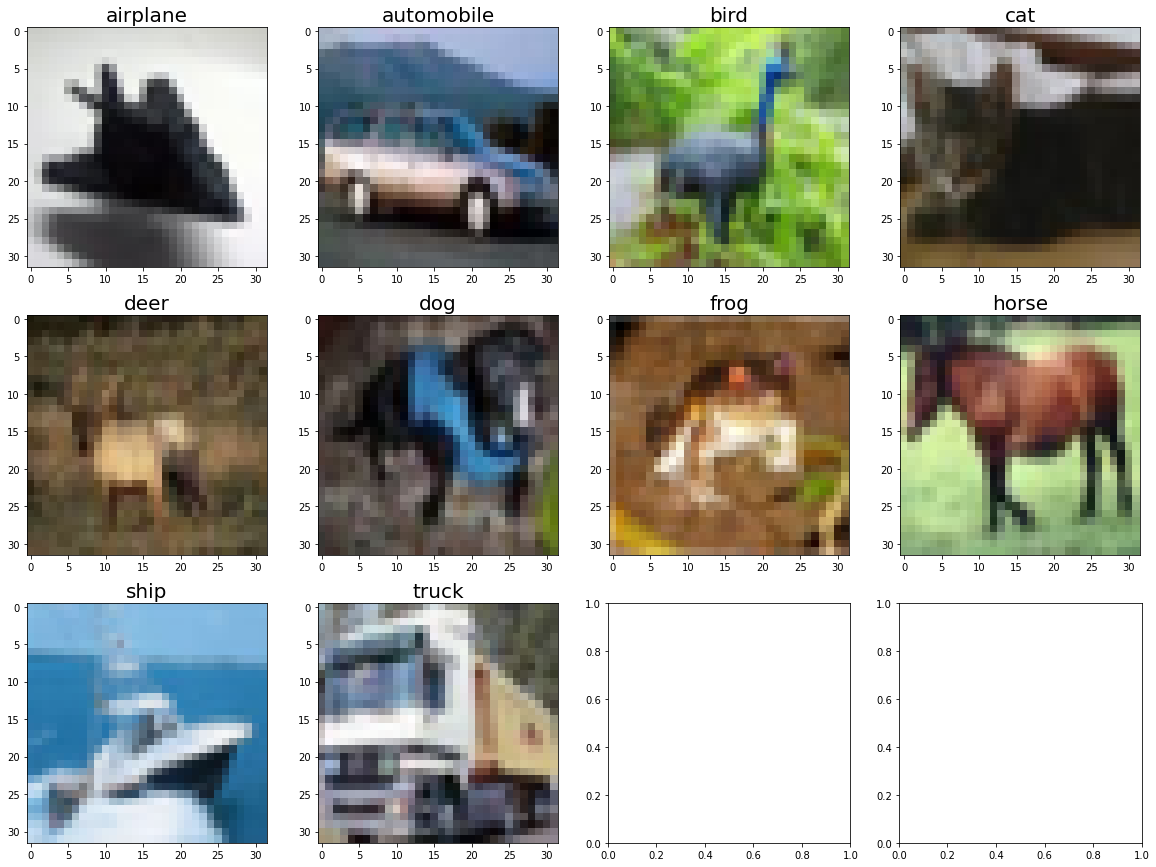

In [62]:
fig, axes = plt.subplots(3, 4, figsize = (20, 15))
for i in range(len(labelNames)):
    axes[i // 4, i % 4].imshow(examples[i].permute(1, 2, 0))
    axes[i // 4, i % 4].set_title(labelNames[i], fontsize = 20)

Создадим загрузчик данных для обучения

In [ ]:
batch_size = 100

train_data_loader = torch.utils.data.DataLoader(
    dataTrain, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    dataTest, batch_size = batch_size, shuffle = False
)

# Модель

In [32]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self):    
        self.network = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),

                nn.Flatten(), 
                nn.Linear(128*16*16, 256),
                nn.ReLU(),
                nn.Linear(256, 10))

    def forward(self, x):
        return self.network(x)

cnn_model = ConvolutionalNeuralNetwork()
cnn_model

(50, 30)
(100, 30)
15


ConvolutionalNeuralNetwork(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=32768, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=10, bias=True)
  )
)

# Обучение модели

In [33]:
learning_rate = 0.1
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)

def get_accuracy(data_loader, model, desc):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, leave=False, desc = desc):
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

trainScore, testScore = [0], [0]
timeSpend = []

pBar = trange(num_epochs, leave=True)
for epoch in pBar:
    timeStart = time.time()
    pBar.set_postfix({'Last train score': round(float(trainScore[-1]), 5), 'test score' : round(float(testScore[-1]), 5)})
    for (images, labels) in tqdm(train_data_loader, leave=False, desc = 'training'):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    timeSpend.append(time.time() - timeStart)
        
    trainScore.append(get_accuracy(train_data_loader, cnn_model, 'Calculating train score'))
    testScore.append(get_accuracy(test_data_loader, cnn_model, 'Calculating test score'))
    
    if trainScore[-1] == 1 and testScore[-1] > 0.7:
        print('Learning finished')
        print(f'Totoal time : {sum(timeSpend)} sec')
        break
    

  0%|          | 0/50 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

training:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating train score:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating test score:   0%|          | 0/101 [00:00<?, ?it/s]

Learning finished
Totoal time : 1880.5594100952148 sec


# Результаты

Покажем графики зависимости точностей (на тренировочной и тестовой выборках) и времени обучения от номера эпохи

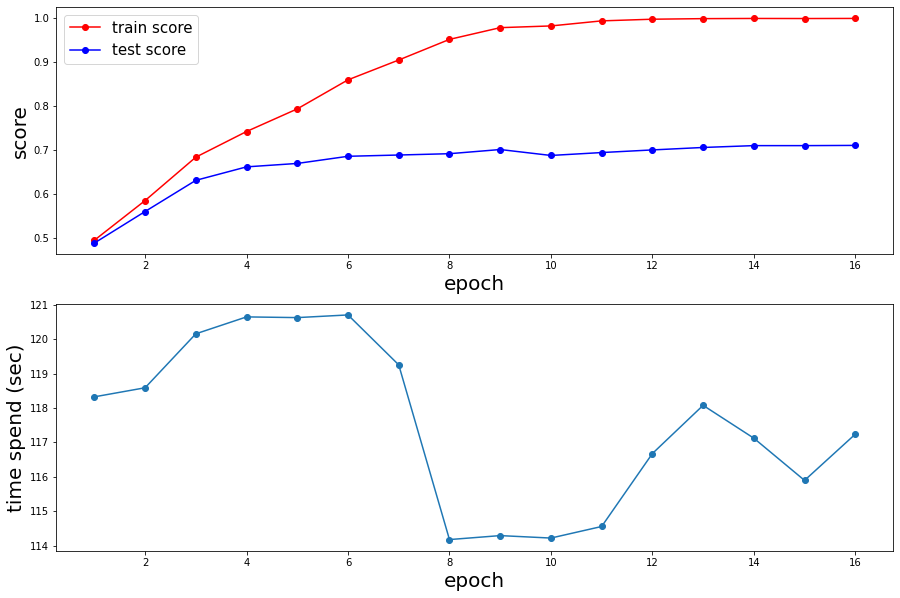

In [34]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize = (15, 10))
ax1.plot([i for i in range(1, len(trainScore))], trainScore[1:], 'r-o', label = 'train score')
ax1.plot([i for i in range(1, len(testScore))], testScore[1:], 'b-o', label = 'test score')
ax1.legend(fontsize = 15)
ax1.set_xlabel('epoch', fontsize = 20)
ax1.set_ylabel('score', fontsize = 20)

ax2.plot([i + 1 for i in range(len(timeSpend))], timeSpend, '-o')
ax2.set_xlabel('epoch', fontsize = 20)
ax2.set_ylabel('time spend (sec)', fontsize = 20)


plt.show()